In [4]:
import os, re,sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

sys.path.append('./')
from models import EfficientKAN, FastKAN, BSRBF_KAN, FasterKAN, MLP, FC_KAN, WCSRBFKAN, WCSRBFKANSolo
from torch.serialization import add_safe_globals
add_safe_globals([
    EfficientKAN, FastKAN, BSRBF_KAN, FasterKAN, MLP, FC_KAN, WCSRBFKAN, WCSRBFKANSolo
])

DISPLAY_DATASET = {"mnist": "MNIST", "fashion_mnist": "Fashion-MNIST"}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
"""

This code picks json files from folder which contain the model training and epoch metrics
Then extracts the best epoch out of how much ever training run you have done
displays the best and average metrics as a table 
and return the details of the best epochs with the best epoch model file name and path

"""


def canon_dataset(name: str) -> str:
    s = name.strip().lower().replace("-", "_")
    if s in {"fashionmnist", "fashion__mnist", "fashion_mnist"}:
        return "fashion_mnist"
    return s

def find_run_idx(path: Path) -> int | None:
    """Return the nearest parent named output<digits>."""
    for p in [path] + list(path.parents):
        m = re.fullmatch(r"output(\d+)", p.name, flags=re.IGNORECASE)
        if m:
            return int(m.group(1))
    return None

def scan_files(root: Path) -> list[dict]:
    """
    Find files like: output*/<dataset>/<model>/<model>__<dataset>__full.json
    Return: dict(run, dataset, model, path, json_name)
    """
    files = list(root.glob("output*/**/*__*__full.json"))
    rows = []
    for fp in files:
        m = re.fullmatch(r"(.+?)__([^_].+?)__full\.json", fp.name, flags=re.IGNORECASE)
        if not m:
            continue
        model = m.group(1).strip().lower()
        dataset = canon_dataset(m.group(2))
        run = find_run_idx(fp)
        if run is None:
            continue
        rows.append({
            "run": run,
            "dataset": dataset,
            "model": model,
            "path": fp.resolve(),
            "json_name": fp.name,
        })
    return rows

def load_json_any(path: Path) -> tuple[pd.DataFrame, float]:
    """Load JSONL (epochs + optional final {'training time': ...}) or JSON array."""
    try:
        df_all = pd.read_json(path, lines=True)
    except ValueError:
        with open(path, "r") as f:
            obj = json.load(f)
        df_all = pd.DataFrame(obj)

    ttime = pd.to_numeric(df_all.get("training time"), errors="coerce").dropna()
    ttime = float(ttime.iloc[0]) if not ttime.empty else np.nan

    if "epoch" not in df_all.columns:
        return pd.DataFrame(), ttime
    df = (df_all.dropna(subset=["val_accuracy"])
                 .sort_values("val_accuracy", ascending=False)
                 .reset_index(drop=True))
    return df, ttime

def percent(x: pd.Series) -> pd.Series:
    return (x * 100).round(2)

def build_display_table(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "dataset" in out:
        out["Dataset"] = out["dataset"].map(DISPLAY_DATASET).fillna(out["dataset"])
    if "model" in out:
        out["#Params"] = out["model"].map(PARAMS).astype("Int64")
    if "train_acc" in out: out["Train. Acc."] = percent(out["train_acc"])
    if "val_acc" in out: out["Val. Acc."]= percent(out["val_acc"])
    if "f1" in out: out["F1"] = percent(out["f1"])
    if "precision" in out: out["precision"] = percent(out["precision"])
    if "recall" in out: out["recall"] = percent(out["recall"])
    if "time_sec"  in out: out["Time (sec)"]  = out["time_sec"].round(1)
    cols = ["Dataset","model","Train. Acc.","Val. Acc.","F1","precision","recall","Time (sec)","#Params",
            "run","final_epoch","json_name","path"]
    return out[[c for c in cols if c in out.columns]]

def table(ROOT):
    records = scan_files(ROOT)
    if not records:
        raise SystemExit("No matching files found (output*/**/*__*__full.json).")

    final_rows = []

    for rec in records:
        df, ttime = load_json_any(rec["path"])
        if df.empty or "val_accuracy" not in df or "train_accuracy" not in df:
            continue

        final = df.loc[df["val_accuracy"].idxmax()]
        final_rows.append({
            "run": rec["run"],
            "dataset": rec["dataset"],
            "model": rec["model"],
            "final_epoch": int(final["epoch"]),
            "val_acc": float(final["val_accuracy"]),
            "train_acc": float(final["train_accuracy"]),
            "f1": float(final.get("f1_macro", np.nan)),
            "precision": float(final.get("pre_macro", np.nan)),
            "recall": float(final.get("re_macro", np.nan)),
            "time_sec": float(ttime),
            "json_name": rec["json_name"],
            "path": str(rec["path"]),
        })

    final_df = pd.DataFrame(final_rows)
    if final_df.empty:
        raise SystemExit("No usable results (missing epoch/accuracy columns).")

    best_final = (
        final_df
        .sort_values(
            by=["dataset","model","val_acc"],
            ascending=[True, True, False]
        )
        .groupby(["dataset","model"], as_index=False)
        .head(1)
    )

    best_table = build_display_table(best_final.sort_values(by=["val_acc"],ascending=[False]))
    print("Best metrics per dataset/model (best epoch by Val. Acc)")
    print(best_table.to_string(index=False))

    avg_per_dataset = (
        final_df
        .groupby(["dataset","model"], as_index=False)
        .agg(train_acc=("train_acc","mean"),
            val_acc=("val_acc","mean"),
            f1=("f1","mean"),
            time_sec=("time_sec","mean"))
    )
    avg_table = build_display_table(avg_per_dataset.sort_values(by=["val_acc"],ascending=[False]))
    print("\nAverage metrics across runs (mean of best epoch by Val. Acc for 3 indipendent training runs) per dataset/model")
    print(avg_table.to_string(index=False))

    return best_table

In [ ]:
""" 

This code was taken from the Github Repo: https://github.com/hoangthangta/FC_KAN

This code block takes the model's path and evaluates it for a selected dataset and gets the mis-classificcations and returns it with metrics

"""

def predict_set(model_path, ds_name, batch_size):
    
    # Load the model
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()  
    
    # Define the image transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) 
    ])
    
    # Load the test set
    if ds_name == 'mnist':
        dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif ds_name == 'fashion_mnist':
        dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset name. Use 'mnist' or 'fashion_mnist'.")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Define loss
    criterion = nn.CrossEntropyLoss()

    # Initialize validation loss and accuracy
    val_loss, val_accuracy = 0, 0   
    
    # List to store predictions
    y_pred = []
    
    # Get true labels
    y_true = [labels.tolist() for _, labels in loader]
    y_true = sum(y_true, [])
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in loader:
            _, _, height, width = images.shape # extract all dimensions
            images = images.view(-1, height*width).to(device)
            output = model(images.to(device))
            val_loss += criterion(output, labels.to(device)).item()
            y_pred += output.argmax(dim=1).tolist()
            val_accuracy += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())
    
    # Calculate F1
    f1 = f1_score(y_true, y_pred, average='macro')
    pre = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    
    # Calculate val loss and val accuracy
    val_loss /= len(loader)
    val_accuracy /= len(loader)
    
    result_dict = {}
    result_dict['val_loss'] = round(val_loss, 6)
    result_dict['val_accuracy'] = round(val_accuracy, 6)
    result_dict['f1'] = round(f1, 6)
    result_dict['pre'] = round(pre, 6)
    result_dict['recall'] = round(recall, 6)
    
    # Create a false inference dictionary
    false_dict = {}
    for x, y in zip(y_true, y_pred):
        if (x != y):
            if (y not in false_dict):
                false_dict[y] = 1
            else:
                false_dict[y] += 1
    false_dict = dict(sorted(false_dict.items(), key=lambda x: x[1], reverse = True))
    
    # Print results
    print(f"Val Loss: {val_loss:.6f}, Val Accuracy: {val_accuracy:.6f}, F1: {f1:.6f}, Precision: {pre:.6f}, Recall: {recall:.6f}")
    print(f"False inference dict: {false_dict}")
    
    return result_dict, false_dict

def get_best_model_paths_dict(result):
    best_model_path = dict()
    for i, r in result.loc[:,["model","path"]].iterrows():
        path_list = r["path"].split("/")
        json_to_pth = path_list[-1].split(".")[0]+".pth"
        best_model_path[r["model"]] = "./"+"/".join(path_list[8:-1])+f"/{json_to_pth}"
    return best_model_path

def compare(best_model_path, ds_name, batch_size):
    result_dict = []
    for model_name, path in best_model_path.items():
        metrics, mistakes = predict_set(path, ds_name, batch_size)
        result_dict.append({model_name: {"metrics": metrics, "errors": mistakes}})
    return result_dict

In [ ]:
"""

This code block takes the mis-classification data returned by the above block and converts it into a heatmap for MNIST dataset

"""

def parse_error_summary_mnist(items):
    rows = []
    acc = {}
    for item in items:
        model, payload = next(iter(item.items()))
        errs = {int(k): int(v) for k, v in payload["errors"].items()}
        row = {d: errs.get(d, 0) for d in range(10)} 
        rows.append(pd.Series(row, name=model))
        acc[model] = payload["metrics"].get("val_accuracy", np.nan)
    df = pd.DataFrame(rows)
    order = sorted(df.index, key=lambda m: acc.get(m, 0), reverse=True)
    df = df.loc[order]
    return df, acc

def plot_error_heatmap_mnist(items, title="MNIST", show_thumbs=True):
    df, acc = parse_error_summary_mnist(items)
    
    yticklabels = [f"{m}  ({acc[m]*100:.2f}%)" if pd.notna(acc[m]) else m for m in df.index]

    fig_h = max(2.5, 0.6 * len(df.index))  
    fig, ax = plt.subplots(figsize=(10, fig_h))

    im = ax.imshow(df.values, cmap="YlGnBu", aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Digit")
    ax.set_ylabel("Model (Val. Acc.)")

    ax.set_xticks(np.arange(10))
    ax.set_xticklabels([str(d) for d in range(10)])
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(yticklabels)

    vals = df.values
    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            ax.text(j, i, f"{int(vals[i, j])}", ha="center", va="center",
                    color="black", fontsize=9)

    cbar = fig.colorbar(im, ax=ax, shrink=0.9)
    cbar.set_label("Misclassified count")

    plt.tight_layout()
    plt.show()

In [ ]:
"""

This code block takes the mis-classification data returned by the above block and converts it into a heatmap for Fashion-MNIST dataset

"""

def parse_error_summary_fashion(items):
    """
    items: list of {model: {'metrics': {...}, 'errors': {class_idx: count, ...}}}
    returns (df: DataFrame[model x class], acc: dict[model->val_acc])
    """
    rows, acc = [], {}
    for it in items:
        model, payload = next(iter(it.items()))
        errs = {int(k): int(v) for k, v in payload["errors"].items()}
        row = {c: errs.get(c, 0) for c in range(10)}
        rows.append(pd.Series(row, name=model))
        acc[model] = float(payload.get("metrics", {}).get("val_accuracy", np.nan))
    df = pd.DataFrame(rows)
    order = sorted(df.index, key=lambda m: acc.get(m, -np.inf), reverse=True)
    df = df.loc[order]
    return df, acc

def plot_error_heatmap_fashion(items, title="Fashion-MNIST", show_thumbs=True):
    df, acc = parse_error_summary_fashion(items)
    df.columns = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

    fig_h = max(2.8, 0.6 * len(df.index))
    fig, ax = plt.subplots(figsize=(10, fig_h))
    axes = (ax,)
    ax = axes[0]
    im = ax.imshow(df.values, cmap="YlGnBu", aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Model (Val. Acc.)")

    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=0, ha="center")
    ylabels = [f"{m}  ({acc[m]*100:.2f}%)" if pd.notna(acc[m]) else m for m in df.index]
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(ylabels)

    v = df.values
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            ax.text(j, i, f"{int(v[i, j])}", ha="center", va="center", fontsize=9, color="black")

    cbar = fig.colorbar(im, ax=ax, shrink=0.9)
    cbar.set_label("Misclassified count")

    plt.tight_layout()
    plt.show()


In [5]:
"""   

This code block Takes a models path, dataset and perplexity and extracts the pen-ultimate features from the model by evaluating the model without the last layer

Then it performs T-SNE and plot the resulting 2-D features and then colors it with class and saves it

"""

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def tsne_plot_for_models(model_name, model_path, ds_name, n_samples, batch_size, perplexity, save_path="./images", seed=42):
    model = torch.load(model_path, weights_only=False)
    save_path = ensure_dir(save_path)
    tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    # testset = getattr(datasets, ds_name)("./data", train=False, download=True, transform=tfm)
    testset = getattr(datasets, ds_name)("./data", train=True, download=True, transform=tfm)

    rng = torch.Generator().manual_seed(seed)
    idx = torch.randperm(len(testset), generator=rng)[:n_samples]
    loader = DataLoader(Subset(testset, idx), batch_size=batch_size, shuffle=False)
    model.eval()

    X,y = None, None

    if model_name=="fc_kan":
        last_layer = model.layers[-1]
        penult_chunks, labels = [], []

        def hook(module, inputs, output):
            # inputs[0] has shape [n_funcs, B, D]
            Xin = inputs[0].detach()                    # [F, B, D]
            H = Xin.permute(1, 0, 2).reshape(Xin.size(1), -1)  # -> [B, F*D]
            penult_chunks.append(H.cpu())

        h = last_layer.register_forward_hook(hook)
        with torch.no_grad():
            for xb, yb in loader:
                B, C, Himg, Wimg = xb.shape
                xb = xb.view(B, Himg * Wimg).to(device) 
                _ = model(xb)                     
                labels.append(yb)

        h.remove()
        X = torch.cat(penult_chunks, dim=0).numpy()     # [N, F*D]
        y = torch.cat(labels, dim=0).numpy()
    else:
        feat_net = torch.nn.Sequential(*list(model.layers)[:-1]).to(device)

        feats, labels = [], []
        with torch.no_grad():
            for xb, yb in loader:
                _, _, height, width = xb.shape 
                xb = xb.view(-1, height*width).to(device)
                H = feat_net(xb) 
                feats.append(H.cpu())
                labels.append(yb)

        X = torch.cat(feats).numpy()
        y = torch.cat(labels).numpy()

    # t-SNE
    Xn = StandardScaler().fit_transform(X)
    Z = TSNE(n_components=2, perplexity=perplexity, init="pca", learning_rate="auto",
            n_iter=1500, random_state=seed).fit_transform(Xn)

    # plot
    plt.figure(figsize=(6.5, 5.5))
    sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=8, alpha=0.85, cmap="tab10")
    if ds_name == "MNIST":
        print(sc.legend_elements())
        plt.legend(*sc.legend_elements(), title="class", fontsize=8, loc="best")
    else:
        names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
        classes = np.unique(y)              # only the classes present in your sample
        cmap, norm = sc.cmap, sc.norm
        handles = [Line2D([0],[0], marker='o', linestyle='', color=cmap(norm(c)), label=names[c]) for c in classes]
        plt.legend(handles=handles, title="class", fontsize=8, loc="best")
        
    plt.title(f"{ds_name} {model_name}: t-SNE of penultimate features")
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{model_name}_{ds_name}_tsne_plot.png"), dpi=180)
    plt.show()

def tsne_looper(best_model_path, ds_name="MNIST", n_samples=3000, batch_size=512, perplexity=30, seed=42, save_path="./images"):
    for model_name, path in best_model_path.items():
        tsne_plot_for_models(model_name, path, ds_name, n_samples=n_samples, batch_size=batch_size, perplexity=perplexity, seed=seed, save_path=save_path)


In [8]:
PARAMS = {
    "bsrbf_kan": 457344,
    "fast_kan": 457418,
    "faster_kan": 406528,
    "efficient_kan": 508160,
    "wcsrbf_kan_un": 457492,
    "wcsrbf_kan_solo": 406602,
    "mlp": 50816,
    "fc_kan": 558979
}

root= Path(f"{os.getcwd()}/output_without_ln")
btable = table(ROOT=root)

Best metrics per dataset/model (best epoch by Val. Acc)
      Dataset           model  Train. Acc.  Val. Acc.    F1  precision  recall  Time (sec)  #Params  run  final_epoch                                 json_name                                                                                                                                         path
        MNIST          fc_kan        99.45      97.66 97.62      97.62   97.62       210.2   558979    2           15                  fc_kan__mnist__full.json                                   /mnt/c/Users/aravi/OneDrive/Desktop/Thesis/output_without_ln/output2/mnist/fc_kan/fc_kan__mnist__full.json
        MNIST             mlp        97.52      97.14 97.11      97.12   97.10       119.5    50816    3           15                     mlp__mnist__full.json                                         /mnt/c/Users/aravi/OneDrive/Desktop/Thesis/output_without_ln/output3/mnist/mlp/mlp__mnist__full.json
        MNIST   wcsrbf_kan_un        97.7

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


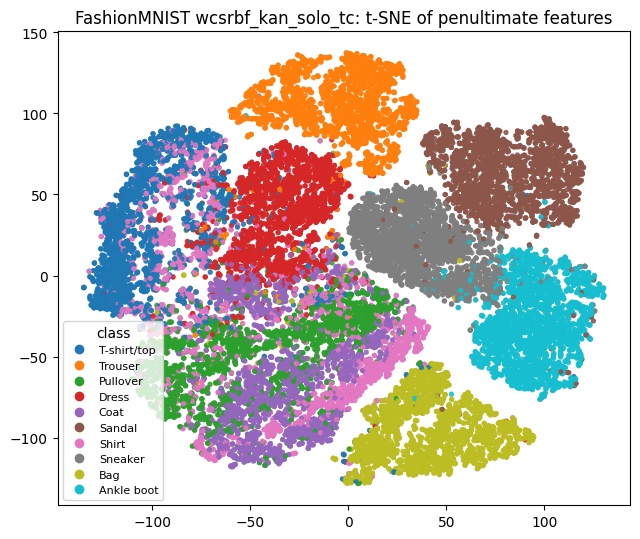

In [7]:
tsne_looper({"wcsrbf_kan_solo_tc": "./wcsrbf_op/output2/fashion_mnist/wcsrbf_kan_solo_tc/wcsrbf_kan_solo_tc__fashion_mnist__full.pth"}, "FashionMNIST", perplexity=10, n_samples=30000, save_path="./train_sample_run")

Val Loss: 0.078097, Val Accuracy: 0.976612, F1: 0.976205, Precision: 0.976238, Recall: 0.976238
False inference dict: {5: 37, 3: 33, 0: 31, 9: 27, 7: 25, 2: 22, 4: 21, 8: 16, 6: 13, 1: 10}
Val Loss: 0.108039, Val Accuracy: 0.971437, F1: 0.971098, Precision: 0.971249, Recall: 0.971041
False inference dict: {9: 43, 0: 37, 3: 33, 7: 31, 6: 28, 2: 27, 8: 25, 5: 24, 1: 21, 4: 18}
Val Loss: 0.130390, Val Accuracy: 0.964172, F1: 0.963682, Precision: 0.963787, Recall: 0.963682
False inference dict: {3: 46, 9: 46, 2: 45, 0: 40, 5: 40, 7: 37, 6: 32, 4: 27, 8: 26, 1: 21}
Val Loss: 0.126631, Val Accuracy: 0.964172, F1: 0.963698, Precision: 0.963799, Recall: 0.963664
False inference dict: {9: 54, 3: 42, 5: 41, 8: 37, 7: 37, 2: 35, 0: 32, 6: 29, 1: 28, 4: 25}
Val Loss: 0.127918, Val Accuracy: 0.962480, F1: 0.961907, Precision: 0.962219, Recall: 0.961791
False inference dict: {9: 67, 3: 57, 5: 39, 0: 37, 6: 32, 7: 31, 8: 31, 2: 29, 1: 27, 4: 27}
Val Loss: 0.154158, Val Accuracy: 0.959096, F1: 0.95853

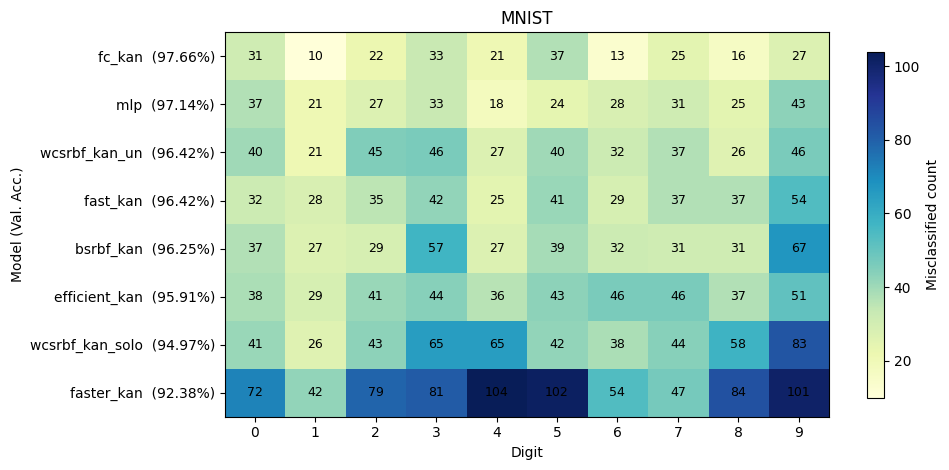

In [ ]:
# result_mnist = btable.query("Dataset=='MNIST'")
# best_model_path_mnist = get_best_model_paths_dict(result_mnist)
# minst_data = compare(best_model_path_mnist, "mnist", 64)
# plot_error_heatmap_mnist(minst_data,"MNIST",True)

In [ ]:
# tsne_looper(best_model_path_mnist, "MNIST", save_path="./sample_run/images_all_mnist")

Val Loss: 0.305824, Val Accuracy: 0.893014, F1: 0.892126, Precision: 0.892088, Recall: 0.892500
False inference dict: {6: 229, 2: 195, 4: 183, 0: 178, 3: 118, 7: 59, 9: 45, 5: 32, 8: 28, 1: 8}
Val Loss: 0.329457, Val Accuracy: 0.882365, F1: 0.881068, Precision: 0.881046, Recall: 0.881800
False inference dict: {6: 245, 4: 217, 2: 204, 0: 185, 3: 144, 7: 62, 9: 48, 5: 33, 8: 31, 1: 13}
Val Loss: 0.330448, Val Accuracy: 0.880772, F1: 0.879569, Precision: 0.879463, Recall: 0.880200
False inference dict: {6: 252, 4: 226, 2: 215, 0: 178, 3: 147, 7: 58, 8: 41, 9: 40, 5: 29, 1: 12}
Val Loss: 0.355097, Val Accuracy: 0.875398, F1: 0.874454, Precision: 0.874378, Recall: 0.874800
False inference dict: {6: 284, 4: 215, 2: 208, 0: 168, 3: 147, 7: 79, 9: 57, 5: 46, 8: 35, 1: 13}
Val Loss: 0.373574, Val Accuracy: 0.867436, F1: 0.866071, Precision: 0.865834, Recall: 0.866800
False inference dict: {6: 275, 4: 234, 2: 233, 0: 180, 3: 158, 7: 83, 5: 57, 9: 51, 8: 42, 1: 19}
Val Loss: 0.409708, Val Accurac

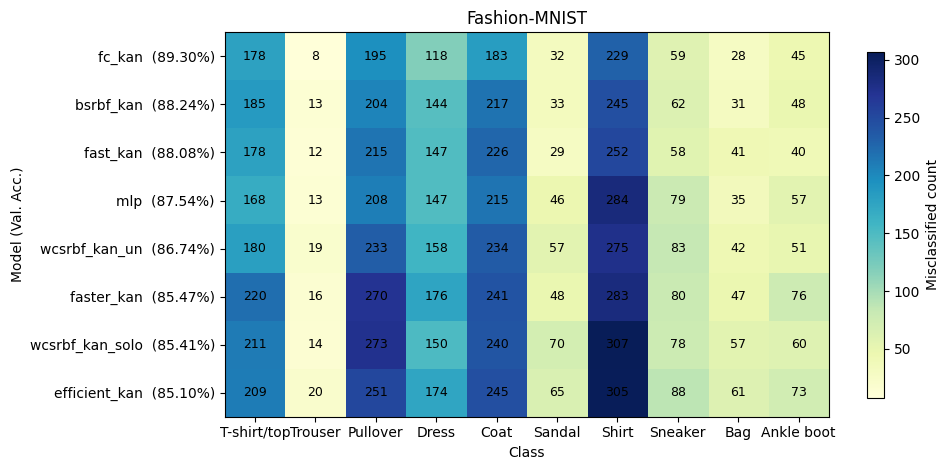

In [11]:
result_fashion = btable.query("Dataset=='Fashion-MNIST'")
best_model_path_fashion = get_best_model_paths_dict(result_fashion)
fashion_data = compare(best_model_path_fashion, "fashion_mnist", 64)
plot_error_heatmap_fashion(fashion_data, title="Fashion-MNIST", show_thumbs=True)

In [ ]:
tsne_looper(best_model_path_fashion, "FashionMNIST", perplexity=10, n_samples=10000, save_path="./sample_run/images_all_fashion")
# tsne_looper({'mlp': './FC_KAN-main/FC_KAN-main/output2/mnist/mlp/mlp__mnist__full.pth'}, "FashionMNIST", perplexity=10, n_samples=10000)

In [13]:
PARAMS = {
    "wcsrbf_kan_un": 457492,
    "wcsrbf_kan_tc_un": 464276,
    "wcsrbf_kan_ts_un": 464276,
    "wcsrbf_kan_tc_ts_un": 471060,
    "wcsrbf_kan_solo": 406602,
    "wcsrbf_kan_solo_tc": 413386,
    "wcsrbf_kan_solo_ts": 413386,
    "wcsrbf_kan_solo_tc_ts": 420170,
}

root = Path(f"{os.getcwd()}/wcsrbf_op")
btable_wcsrbf = table(ROOT=root)

Best metrics per dataset/model (best epoch by Val. Acc)
      Dataset                 model  Train. Acc.  Val. Acc.    F1  precision  recall  Time (sec)  #Params  run  final_epoch                                       json_name                                                                                                                                             path
        MNIST   wcsrbf_kan_tc_ts_un        98.50      97.59 97.57      97.57   97.57       160.7   471060    2           15           wcsrbf_kan_tc_ts_un__mnist__full.json                     /mnt/c/Users/aravi/OneDrive/Desktop/Thesis/wcsrbf_op/output2/mnist/wcsrbf_kan_tc_ts_un/wcsrbf_kan_tc_ts_un__mnist__full.json
        MNIST      wcsrbf_kan_ts_un        97.79      97.04 97.01      97.02   97.00       161.7   464276    2           15              wcsrbf_kan_ts_un__mnist__full.json                           /mnt/c/Users/aravi/OneDrive/Desktop/Thesis/wcsrbf_op/output2/mnist/wcsrbf_kan_ts_un/wcsrbf_kan_ts_un__mnist__ful

Val Loss: 0.089270, Val Accuracy: 0.975916, F1: 0.975665, Precision: 0.975680, Recall: 0.975688
False inference dict: {9: 32, 2: 29, 3: 29, 0: 27, 8: 25, 7: 24, 5: 23, 6: 21, 4: 17, 1: 15}
Val Loss: 0.105072, Val Accuracy: 0.970442, F1: 0.970102, Precision: 0.970244, Recall: 0.970032
False inference dict: {3: 38, 9: 35, 5: 35, 1: 35, 6: 28, 8: 28, 7: 26, 2: 25, 0: 24, 4: 23}
Val Loss: 0.108319, Val Accuracy: 0.968949, F1: 0.968426, Precision: 0.968457, Recall: 0.968536
False inference dict: {5: 52, 9: 42, 6: 31, 4: 31, 0: 31, 3: 28, 7: 28, 2: 24, 1: 23, 8: 22}
Val Loss: 0.110087, Val Accuracy: 0.968850, F1: 0.968464, Precision: 0.968574, Recall: 0.968419
False inference dict: {2: 40, 9: 40, 3: 36, 0: 32, 6: 31, 7: 30, 5: 30, 4: 26, 8: 25, 1: 23}
Val Loss: 0.130390, Val Accuracy: 0.964172, F1: 0.963682, Precision: 0.963787, Recall: 0.963682
False inference dict: {3: 46, 9: 46, 2: 45, 0: 40, 5: 40, 7: 37, 6: 32, 4: 27, 8: 26, 1: 21}
Val Loss: 0.136439, Val Accuracy: 0.960589, F1: 0.96000

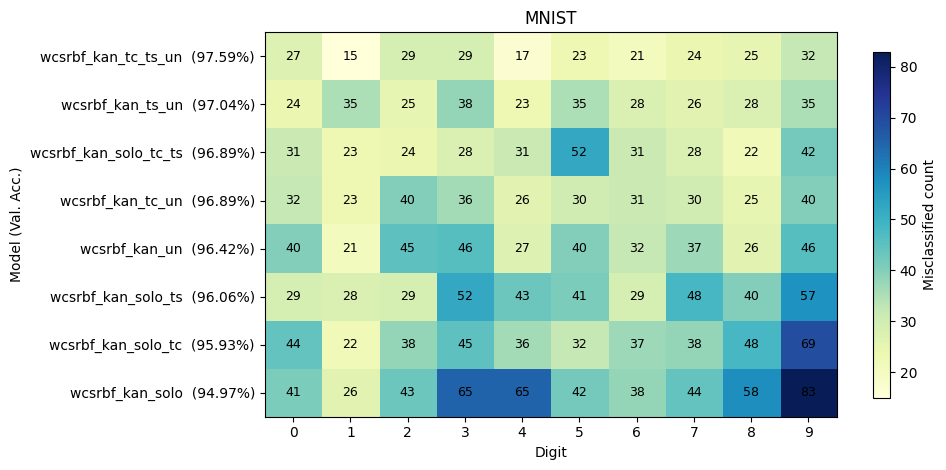

In [14]:
result_mnist_wcsrbf = btable_wcsrbf.query("Dataset=='MNIST'")
best_model_path_mnist_wcsrbf = get_best_model_paths_dict(result_mnist_wcsrbf)
minst_data_wcsrbf = compare(best_model_path_mnist_wcsrbf, "mnist", 64)
plot_error_heatmap_mnist(minst_data_wcsrbf,"MNIST",True)

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


([<matplotlib.lines.Line2D object at 0x7f873d3b4fb0>, <matplotlib.lines.Line2D object at 0x7f87342b6570>, <matplotlib.lines.Line2D object at 0x7f8734357b60>, <matplotlib.lines.Line2D object at 0x7f87342b4860>, <matplotlib.lines.Line2D object at 0x7f87342b5280>, <matplotlib.lines.Line2D object at 0x7f87342b6f30>, <matplotlib.lines.Line2D object at 0x7f87342b4950>, <matplotlib.lines.Line2D object at 0x7f87342b75f0>, <matplotlib.lines.Line2D object at 0x7f8734382300>, <matplotlib.lines.Line2D object at 0x7f87342b6f60>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$'])


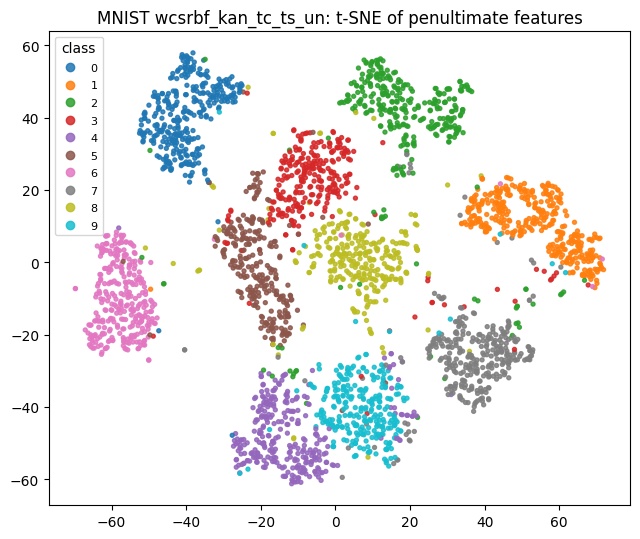

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


([<matplotlib.lines.Line2D object at 0x7f873d7d5280>, <matplotlib.lines.Line2D object at 0x7f873d7d4050>, <matplotlib.lines.Line2D object at 0x7f873d7d47a0>, <matplotlib.lines.Line2D object at 0x7f87342b6c30>, <matplotlib.lines.Line2D object at 0x7f87342b4950>, <matplotlib.lines.Line2D object at 0x7f87342b69c0>, <matplotlib.lines.Line2D object at 0x7f8734226060>, <matplotlib.lines.Line2D object at 0x7f874809d070>, <matplotlib.lines.Line2D object at 0x7f873d36cb00>, <matplotlib.lines.Line2D object at 0x7f873d36d1c0>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$'])


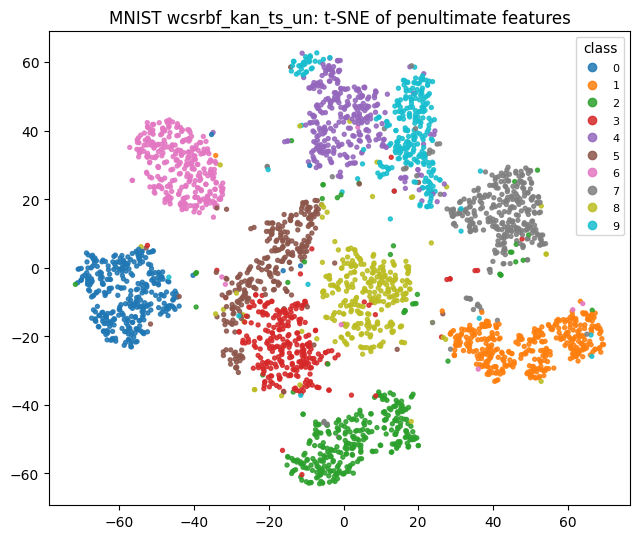

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


([<matplotlib.lines.Line2D object at 0x7f873d7e2f60>, <matplotlib.lines.Line2D object at 0x7f874aa82bd0>, <matplotlib.lines.Line2D object at 0x7f874aa832f0>, <matplotlib.lines.Line2D object at 0x7f874aa83470>, <matplotlib.lines.Line2D object at 0x7f873d7e3b00>, <matplotlib.lines.Line2D object at 0x7f8748bc7260>, <matplotlib.lines.Line2D object at 0x7f873d7f9700>, <matplotlib.lines.Line2D object at 0x7f874aa83590>, <matplotlib.lines.Line2D object at 0x7f874aabac00>, <matplotlib.lines.Line2D object at 0x7f874aaba810>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$'])


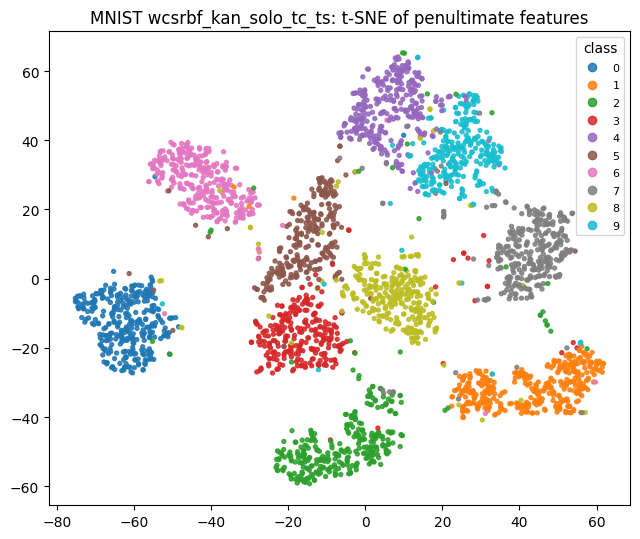

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


([<matplotlib.lines.Line2D object at 0x7f8748b62ed0>, <matplotlib.lines.Line2D object at 0x7f874d5c8ce0>, <matplotlib.lines.Line2D object at 0x7f8748b63d10>, <matplotlib.lines.Line2D object at 0x7f873d742b10>, <matplotlib.lines.Line2D object at 0x7f8748b61af0>, <matplotlib.lines.Line2D object at 0x7f874aa83530>, <matplotlib.lines.Line2D object at 0x7f8748bc6de0>, <matplotlib.lines.Line2D object at 0x7f874809da60>, <matplotlib.lines.Line2D object at 0x7f874aa678f0>, <matplotlib.lines.Line2D object at 0x7f8748b62990>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$'])


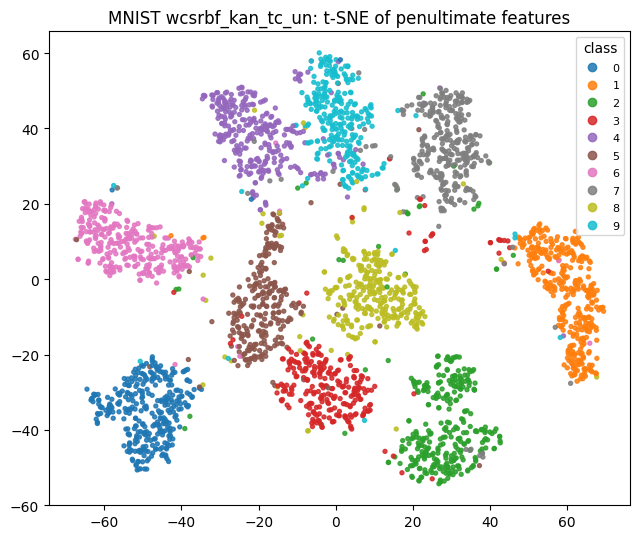

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


([<matplotlib.lines.Line2D object at 0x7f8748b2d760>, <matplotlib.lines.Line2D object at 0x7f8748b2f140>, <matplotlib.lines.Line2D object at 0x7f8748b05a60>, <matplotlib.lines.Line2D object at 0x7f8748b5b500>, <matplotlib.lines.Line2D object at 0x7f8748b59280>, <matplotlib.lines.Line2D object at 0x7f873d7f8d70>, <matplotlib.lines.Line2D object at 0x7f8748b2c860>, <matplotlib.lines.Line2D object at 0x7f874aa640b0>, <matplotlib.lines.Line2D object at 0x7f874aab9f10>, <matplotlib.lines.Line2D object at 0x7f874aaba8a0>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$'])


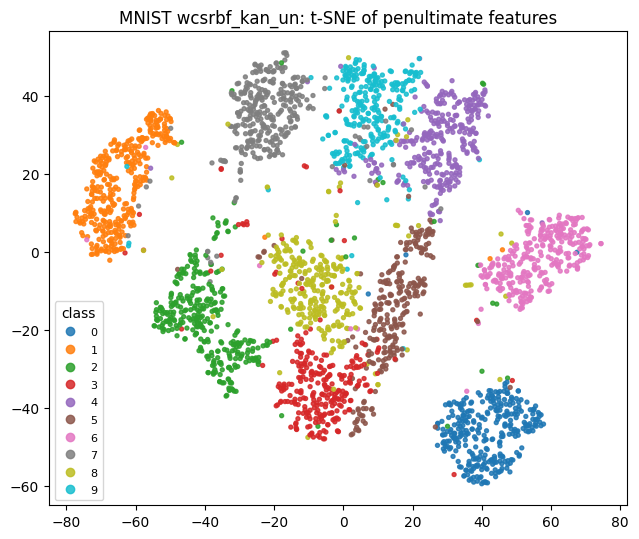

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


([<matplotlib.lines.Line2D object at 0x7f8728505c40>, <matplotlib.lines.Line2D object at 0x7f8728504ec0>, <matplotlib.lines.Line2D object at 0x7f87342ca2a0>, <matplotlib.lines.Line2D object at 0x7f8728506f60>, <matplotlib.lines.Line2D object at 0x7f874ac7d1c0>, <matplotlib.lines.Line2D object at 0x7f8748b7c860>, <matplotlib.lines.Line2D object at 0x7f8728323ad0>, <matplotlib.lines.Line2D object at 0x7f87285057c0>, <matplotlib.lines.Line2D object at 0x7f87342b6db0>, <matplotlib.lines.Line2D object at 0x7f8728505ac0>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$'])


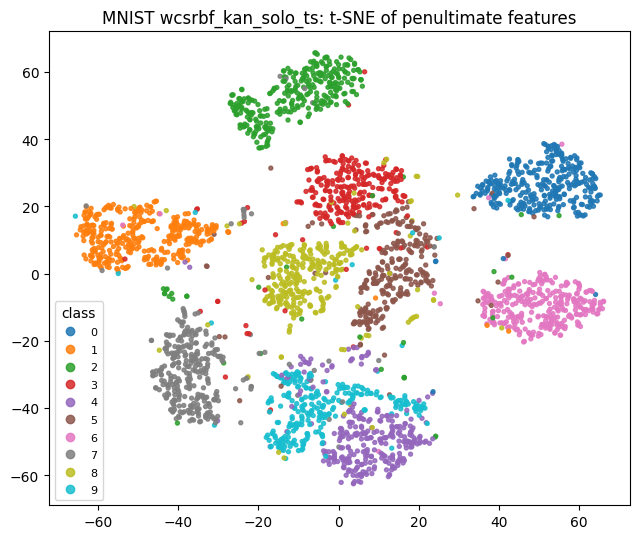

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


([<matplotlib.lines.Line2D object at 0x7f872831af60>, <matplotlib.lines.Line2D object at 0x7f8728403dd0>, <matplotlib.lines.Line2D object at 0x7f87480b8170>, <matplotlib.lines.Line2D object at 0x7f87284017c0>, <matplotlib.lines.Line2D object at 0x7f872839ff80>, <matplotlib.lines.Line2D object at 0x7f8728400fe0>, <matplotlib.lines.Line2D object at 0x7f8728505d90>, <matplotlib.lines.Line2D object at 0x7f87342cb890>, <matplotlib.lines.Line2D object at 0x7f872839f800>, <matplotlib.lines.Line2D object at 0x7f8728403350>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$'])


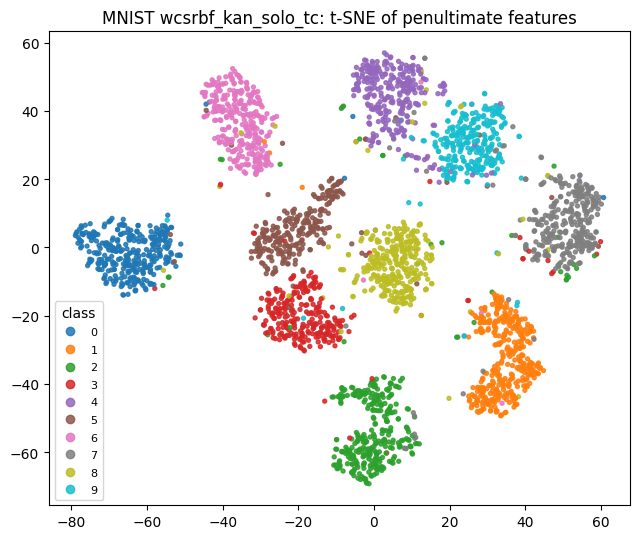

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


([<matplotlib.lines.Line2D object at 0x7f8748b2fec0>, <matplotlib.lines.Line2D object at 0x7f87282f2b40>, <matplotlib.lines.Line2D object at 0x7f87282a1d90>, <matplotlib.lines.Line2D object at 0x7f8728403230>, <matplotlib.lines.Line2D object at 0x7f87282a37a0>, <matplotlib.lines.Line2D object at 0x7f8728403b30>, <matplotlib.lines.Line2D object at 0x7f87284038c0>, <matplotlib.lines.Line2D object at 0x7f87283c9730>, <matplotlib.lines.Line2D object at 0x7f8728400410>, <matplotlib.lines.Line2D object at 0x7f8728257a70>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$'])


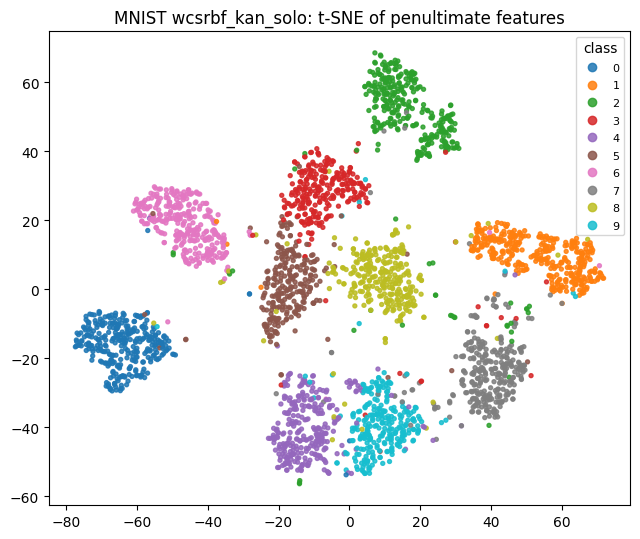

In [15]:
tsne_looper(best_model_path_mnist_wcsrbf, "MNIST", save_path="./sample_run/images_wcsrbf_mnist")

Val Loss: 0.323948, Val Accuracy: 0.886943, F1: 0.885745, Precision: 0.885849, Recall: 0.886400
False inference dict: {6: 223, 4: 219, 2: 190, 0: 174, 3: 141, 7: 55, 9: 54, 5: 35, 8: 33, 1: 12}
Val Loss: 0.323089, Val Accuracy: 0.884057, F1: 0.883072, Precision: 0.883223, Recall: 0.883800
False inference dict: {6: 222, 4: 221, 2: 198, 0: 184, 3: 146, 9: 59, 7: 52, 5: 38, 8: 30, 1: 12}
Val Loss: 0.330085, Val Accuracy: 0.879976, F1: 0.879289, Precision: 0.879205, Recall: 0.879700
False inference dict: {6: 273, 4: 218, 2: 202, 0: 188, 3: 131, 7: 63, 9: 49, 8: 38, 5: 31, 1: 10}
Val Loss: 0.337068, Val Accuracy: 0.879678, F1: 0.878638, Precision: 0.878608, Recall: 0.879100
False inference dict: {6: 271, 4: 221, 2: 208, 0: 182, 3: 135, 7: 60, 9: 51, 5: 39, 8: 34, 1: 8}
Val Loss: 0.342721, Val Accuracy: 0.879379, F1: 0.877975, Precision: 0.877781, Recall: 0.878800
False inference dict: {6: 252, 2: 218, 4: 217, 0: 173, 3: 149, 7: 64, 9: 54, 5: 37, 8: 36, 1: 12}
Val Loss: 0.392258, Val Accurac

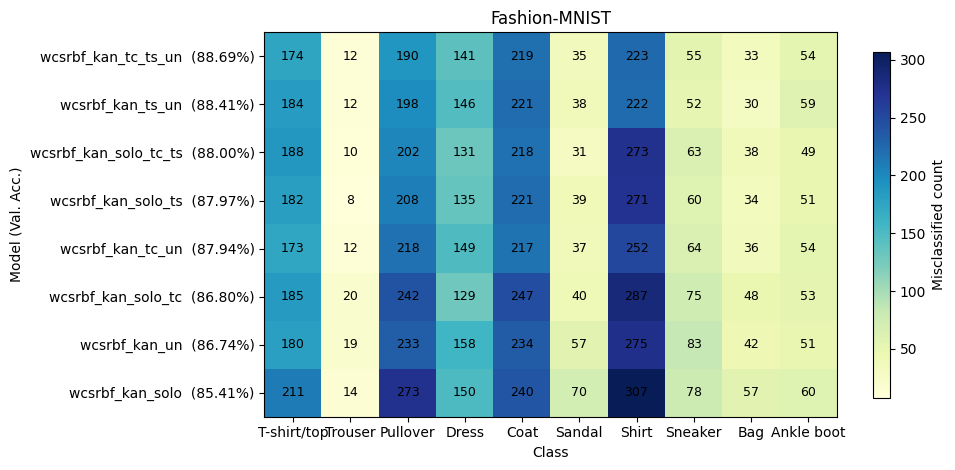

In [16]:
result_fashion_wcsrbf = btable_wcsrbf.query("Dataset=='Fashion-MNIST'")
best_model_path_fashion_wcsrbf = get_best_model_paths_dict(result_fashion_wcsrbf)
fashion_data_wcsrbf = compare(best_model_path_fashion_wcsrbf, "fashion_mnist", 64)
plot_error_heatmap_fashion(fashion_data_wcsrbf, title="Fashion-MNIST", show_thumbs=True)

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


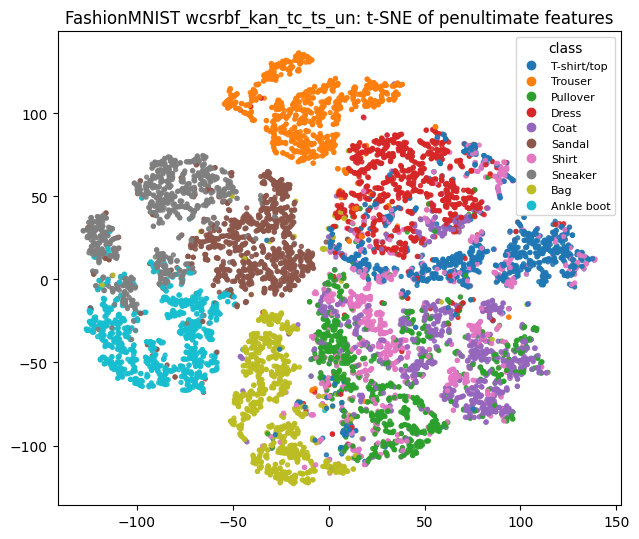

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


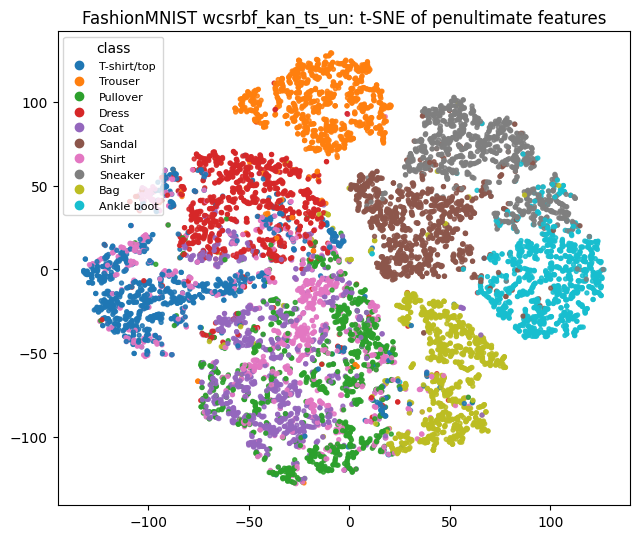

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


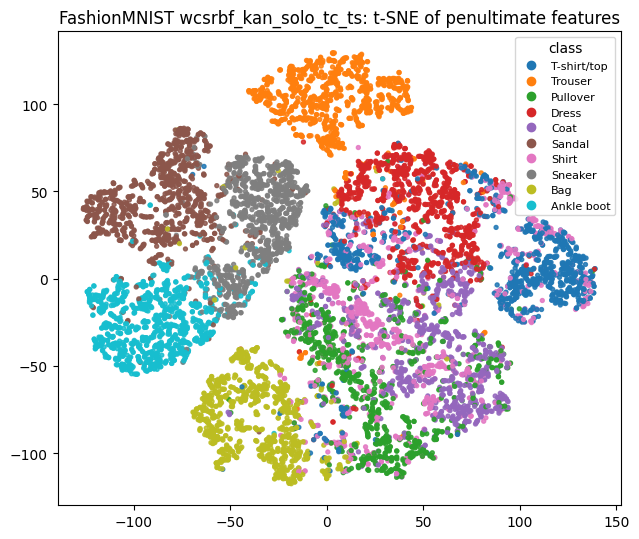

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


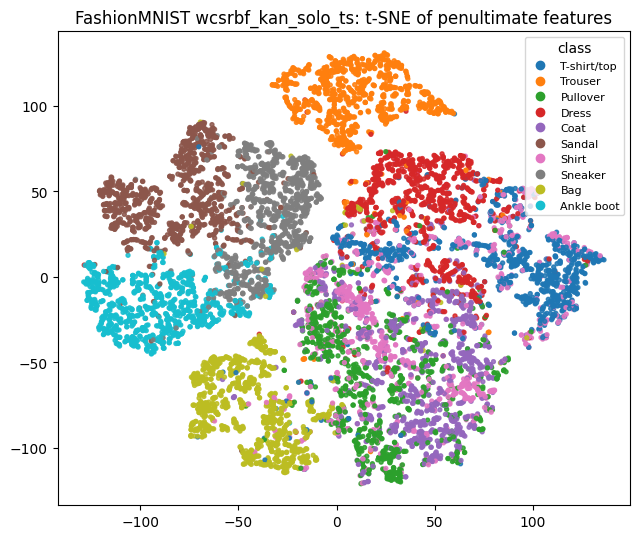

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


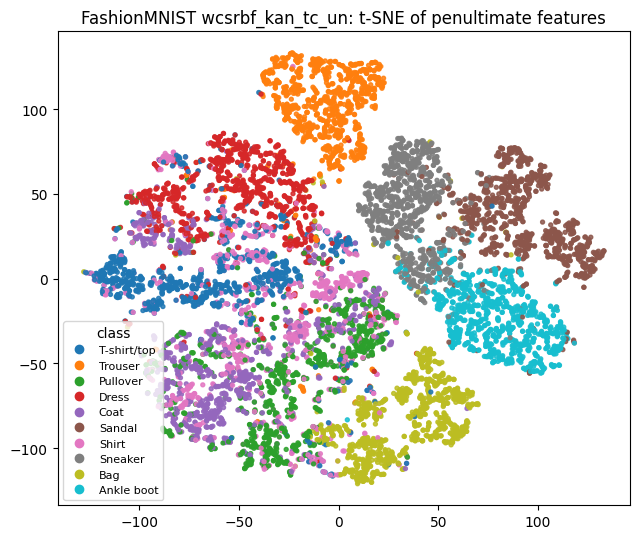

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


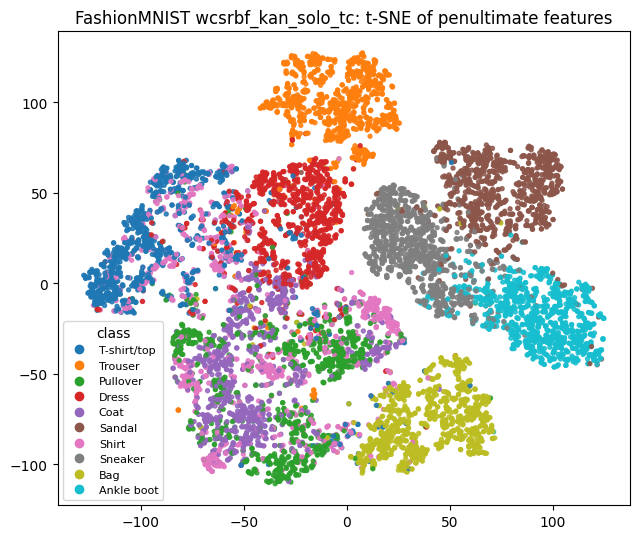

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


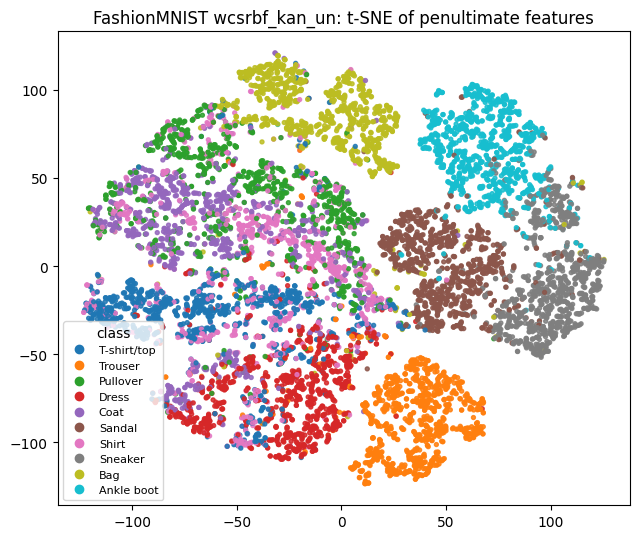

/home/aknero/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


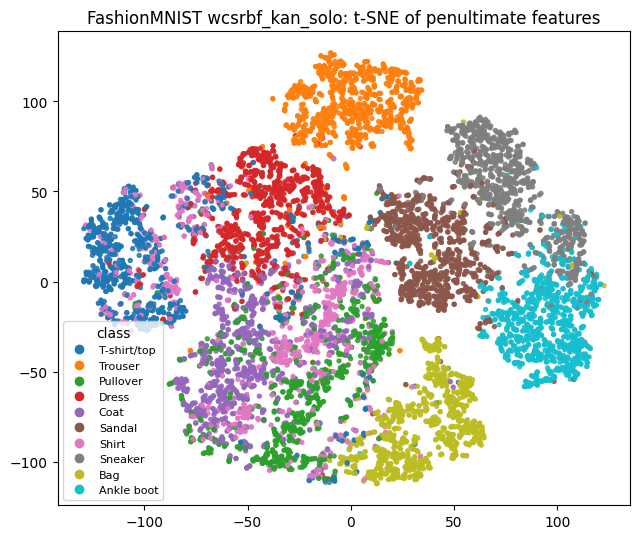

In [17]:
tsne_looper(best_model_path_fashion_wcsrbf, "FashionMNIST", perplexity=10, n_samples=10000, save_path="./sample_run/images_wcsrbf_fashion")